#### Topic: Hw6, Machine-Learning-2019-fall
#### Date: 2019-12-13
#### Author: 林俊儒(B063040058), 王譽鈞(B065040034)

---
#### 1.分別利用 Autoencoder 及 GAN 機制訓練一個神經網路
#### 可以針對輸入T, 產生 (x1 , x2 )的資料
#### 其中(x1 , x2 )滿足函數:   $x_1 - cos(0.2\pi \times x_2) = 0.5$

---
#### PART A: Auto-encoder

#### 先產生資料集

In [1]:
from math import cos, pi, sin, tanh
import numpy as np
from matplotlib import pyplot as plt

def MyFunction(n=1000):
    x1 = []
    x2 = np.linspace(-10,10,n)
    for i in range(len(x2)):
        x1.append(cos(0.2*pi*x2[i])+0.5)
    x1 = np.asarray(x1)
    return x2, x1

x1, x2 = MyFunction(1000)

data = list([x,y] for x,y in zip(x1,x2))
data = np.asarray(data)
np.random.shuffle(data)

#### build AutoEncoder model

In [3]:
from keras.layers import Input, Dense, LeakyReLU
from keras.models import Model
from keras import optimizers
from keras.layers.normalization import BatchNormalization

encoding_dim = 1

input_coor = Input(shape=(2,))
x = Dense(16, activation=LeakyReLU(alpha=0.3))(input_coor)
x = Dense(16, activation=LeakyReLU(alpha=0.3))(x)
encoded = Dense(encoding_dim, activation=LeakyReLU(alpha=0.3))(x)
x = Dense(16, activation=LeakyReLU(alpha=0.3))(encoded)
x = Dense(16, activation=LeakyReLU(alpha=0.3))(x)
decoded = Dense(2, activation='linear')(x)

autoencoder = Model(input_coor, decoded)
autoencoder.compile(optimizer='adam', loss='mse')
initial_weights = autoencoder.get_weights()

#### 我們的model模型如下:

In [4]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 34        
Total para

#### 取出model中encoder和decoder 

In [5]:
encoder = Model(input_coor, encoded)
encoded_input = Input(shape=(encoding_dim,))
layer1 = autoencoder.layers[-3]
layer2 = autoencoder.layers[-2]
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(layer2(layer1(encoded_input))))

#### 我們讓每個epoch 跑的訓練點個數為 256
#### epoch 設定 1000 次
#### 每10次 印出目前訓練成果

1000/1000 [==============================] - 0s 33us/step
Iterations: 100	 loss(mse): 0.23096


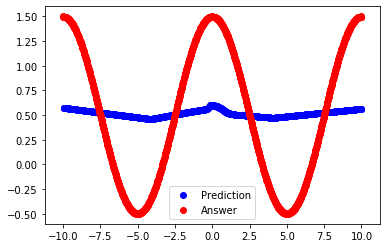

1000/1000 [==============================] - 0s 32us/step
Iterations: 200	 loss(mse): 0.18569


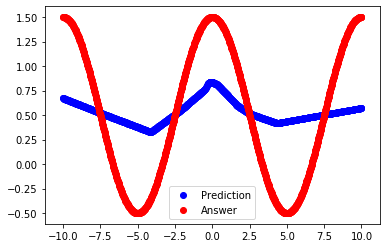

1000/1000 [==============================] - 0s 29us/step
Iterations: 300	 loss(mse): 0.10138


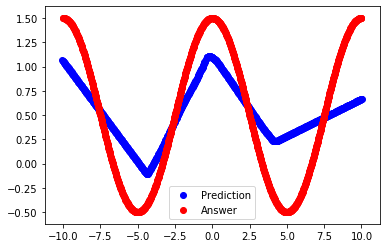

1000/1000 [==============================] - 0s 14us/step
Iterations: 400	 loss(mse): 0.03840


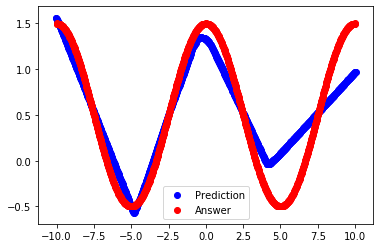

1000/1000 [==============================] - 0s 31us/step
Iterations: 500	 loss(mse): 0.01317


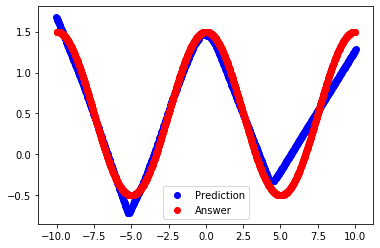

1000/1000 [==============================] - 0s 27us/step
Iterations: 600	 loss(mse): 0.00397


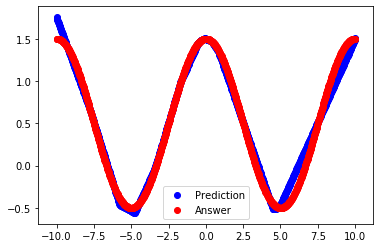

1000/1000 [==============================] - 0s 21us/step
Iterations: 700	 loss(mse): 0.00185


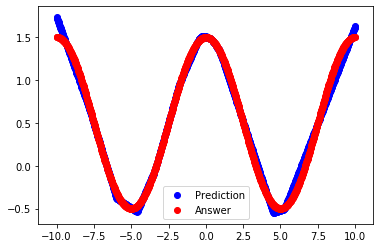

1000/1000 [==============================] - 0s 28us/step
Iterations: 800	 loss(mse): 0.00135


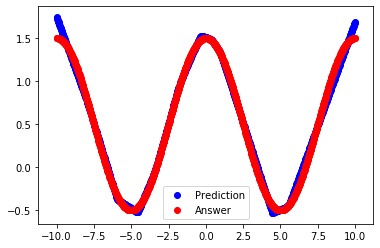

1000/1000 [==============================] - 0s 36us/step
Iterations: 900	 loss(mse): 0.00123


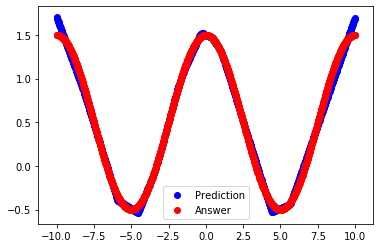

1000/1000 [==============================] - 0s 30us/step
Iterations: 1000	 loss(mse): 0.00118


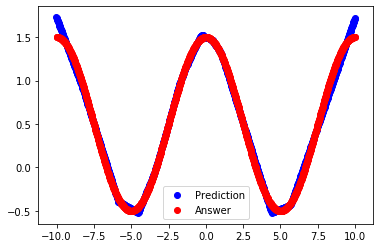

In [8]:
autoencoder.set_weights(initial_weights)
for i in range(10):
    autoencoder.fit(data, data, epochs=100, batch_size=256, validation_split=0.2, verbose=0)
    encoded_coor = encoder.predict(data)
    decoded_coor = decoder.predict(encoded_coor)
    px = []
    py = []
    for j in range(len(decoded_coor)):
        px.append(decoded_coor[j][0])
        py.append(decoded_coor[j][1])

    loss = autoencoder.evaluate(data, data)
    msg = 'Iterations: %d\t loss(mse): %.5f' % ((i+1)*100,loss)
    print(msg)
    plt.scatter(px,py,color='b',label = 'Prediction')
    plt.scatter(x1,x2,color='r',label = 'Answer')
    plt.legend()
    plt.show()

#### 探討不同 t 值對應於空間的點

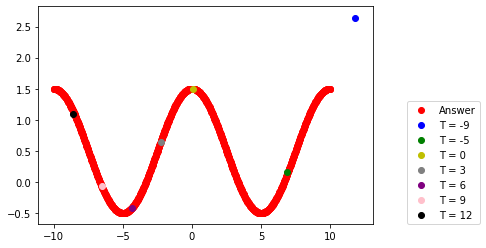

In [11]:
t_list = [-9,-5,0,3,6,9,12]
t_list = np.asarray(t_list)
decoded_coor = decoder.predict(t_list)

x = []
y = []
for i in range(len(decoded_coor)):
    x.append(decoded_coor[i][0])
    y.append(decoded_coor[i][1])

plt.scatter(x1,x2,color='r',label = 'Answer')
plt.scatter(x[0],y[0],color='b',label = 'T = -9')
plt.scatter(x[1],y[1],color='g',label = 'T = -5')
plt.scatter(x[2],y[2],color='y',label = 'T = 0')
plt.scatter(x[3],y[3],color='gray',label = 'T = 3')
plt.scatter(x[4],y[4],color='purple',label = 'T = 6')
plt.scatter(x[5],y[5],color='pink',label = 'T = 9')
plt.scatter(x[6],y[6],color='black',label = 'T = 12')
plt.legend(loc=[1.1, 0])
plt.show()

#### 映射的分佈情形 大致為平均分散的分佈。
#### 而超過預設範圍的資料，
#### 則以類似原資料邊緣的方向 繼續往同方向延伸的方式出現
#### 變得沒有參考價值
---
##### 接著我們測試如果訓練之點數 減少的情形
##### 給的點數量 從1000降到100

In [12]:
x1, x2 = MyFunction(100)

data = list([x,y] for x,y in zip(x1,x2))
data = np.asarray(data)
np.random.shuffle(data)

100/100 [==============================] - 0s 48us/step
Iterations: 100	 loss(mse): 0.25297


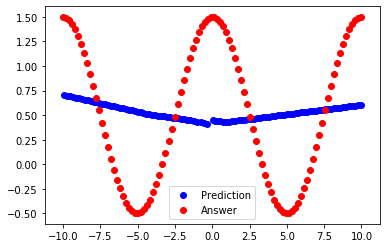

100/100 [==============================] - 0s 154us/step
Iterations: 200	 loss(mse): 0.24479


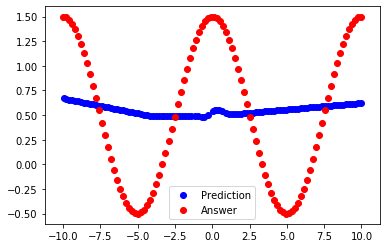

100/100 [==============================] - 0s 44us/step
Iterations: 300	 loss(mse): 0.23119


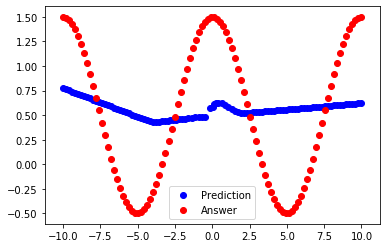

100/100 [==============================] - 0s 44us/step
Iterations: 400	 loss(mse): 0.20681


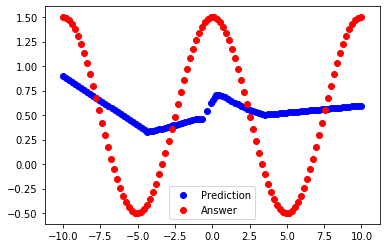

100/100 [==============================] - 0s 44us/step
Iterations: 500	 loss(mse): 0.17872


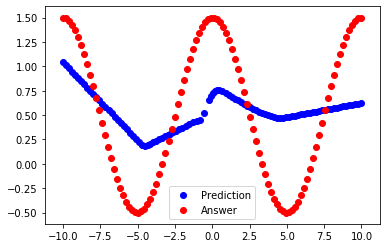

100/100 [==============================] - 0s 74us/step
Iterations: 600	 loss(mse): 0.14799


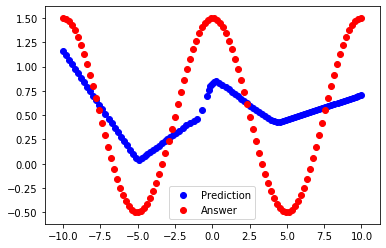

100/100 [==============================] - 0s 48us/step
Iterations: 700	 loss(mse): 0.11305


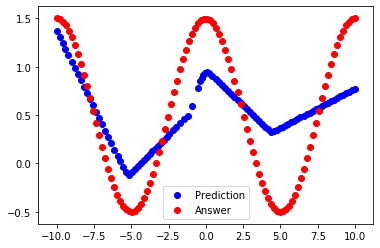

100/100 [==============================] - 0s 41us/step
Iterations: 800	 loss(mse): 0.07508


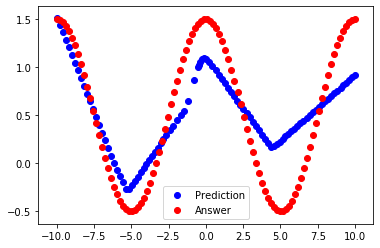

100/100 [==============================] - 0s 47us/step
Iterations: 900	 loss(mse): 0.04034


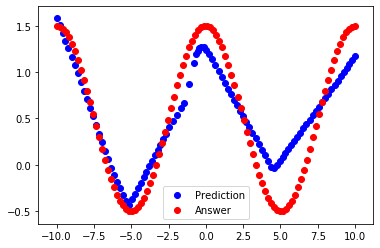

100/100 [==============================] - 0s 94us/step
Iterations: 1000	 loss(mse): 0.01597


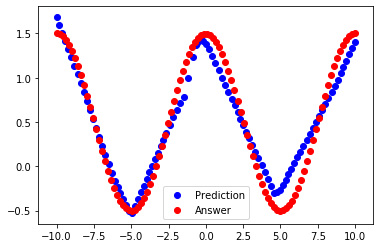

100/100 [==============================] - 0s 82us/step
Iterations: 1100	 loss(mse): 0.00570


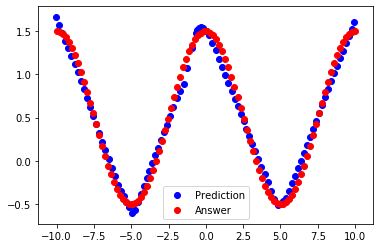

100/100 [==============================] - 0s 43us/step
Iterations: 1200	 loss(mse): 0.00391


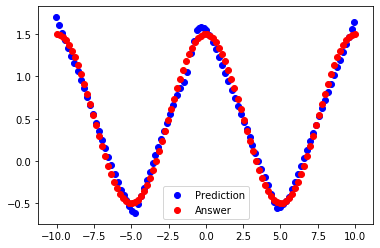

100/100 [==============================] - 0s 42us/step
Iterations: 1300	 loss(mse): 0.00319


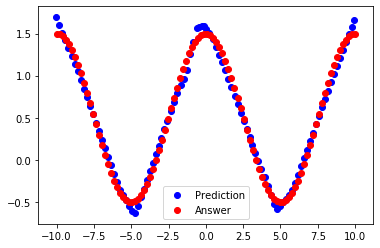

100/100 [==============================] - 0s 43us/step
Iterations: 1400	 loss(mse): 0.00290


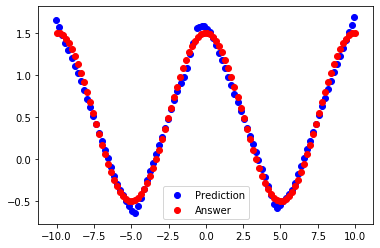

100/100 [==============================] - 0s 44us/step
Iterations: 1500	 loss(mse): 0.00269


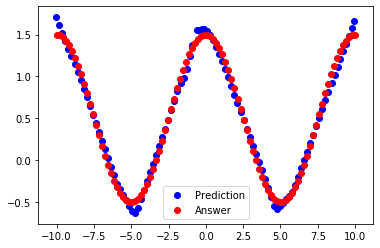

100/100 [==============================] - 0s 42us/step
Iterations: 1600	 loss(mse): 0.00248


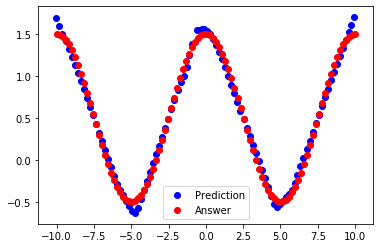

100/100 [==============================] - 0s 42us/step
Iterations: 1700	 loss(mse): 0.00264


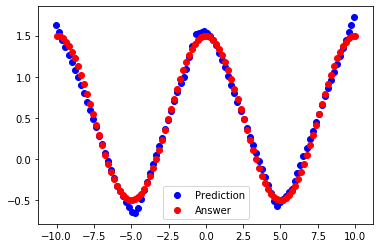

100/100 [==============================] - 0s 118us/step
Iterations: 1800	 loss(mse): 0.00219


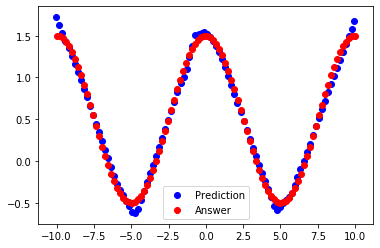

100/100 [==============================] - 0s 111us/step
Iterations: 1900	 loss(mse): 0.00207


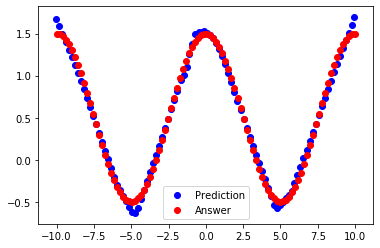

100/100 [==============================] - 0s 46us/step
Iterations: 2000	 loss(mse): 0.00238


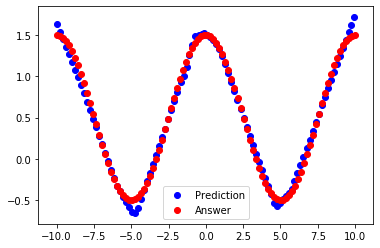

In [13]:
autoencoder.set_weights(initial_weights)
for i in range(20):
    autoencoder.fit(data, data, epochs=100, batch_size=50, validation_split=0.2, verbose=0)
    encoded_coor = encoder.predict(data)
    decoded_coor = decoder.predict(encoded_coor)
    px = []
    py = []
    for j in range(len(decoded_coor)):
        px.append(decoded_coor[j][0])
        py.append(decoded_coor[j][1])

    loss = autoencoder.evaluate(data, data)
    msg = 'Iterations: %d\t loss(mse): %.5f' % ((i+1)*100,loss)
    print(msg)
    plt.scatter(px,py,color='b',label = 'Prediction')
    plt.scatter(x1,x2,color='r',label = 'Answer')
    plt.legend()
    plt.show()

#### 可以發現一開始給的資料變少，需要花更多的epochs次數才能得到比較好的結果(這次提升到2000次)

#### 我們換成 同一個邊界範圍的sin函數跑跑看

In [14]:
def MyFunctionSin(n=1000):
    x1 = []
    x2 = np.linspace(-10,10,n)
    for i in range(len(x2)):
        x1.append(sin(0.2*pi*x2[i])+0.5)
    x1 = np.asarray(x1)
    return x2, x1

x1, x2 = MyFunctionSin(1000)

data = list([x,y] for x,y in zip(x1,x2))
data = np.asarray(data)
np.random.shuffle(data)

1000/1000 [==============================] - 0s 33us/step
Iterations: 100	 loss(mse): 0.12108


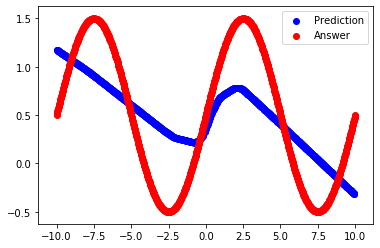

1000/1000 [==============================] - 0s 14us/step
Iterations: 200	 loss(mse): 0.06776


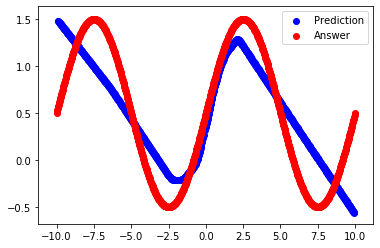

1000/1000 [==============================] - 0s 34us/step
Iterations: 300	 loss(mse): 0.06403


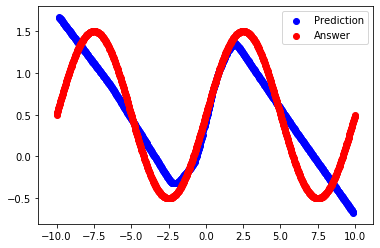

1000/1000 [==============================] - 0s 46us/step
Iterations: 400	 loss(mse): 0.06063


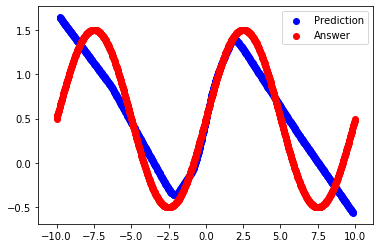

1000/1000 [==============================] - 0s 24us/step
Iterations: 500	 loss(mse): 0.05640


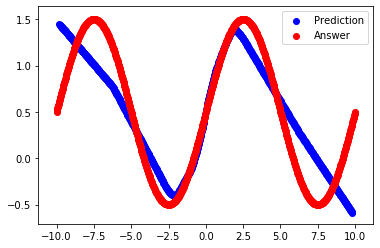

1000/1000 [==============================] - 0s 14us/step
Iterations: 600	 loss(mse): 0.05214


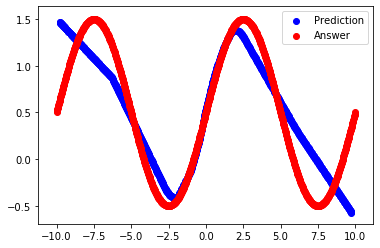

1000/1000 [==============================] - 0s 25us/step
Iterations: 700	 loss(mse): 0.04746


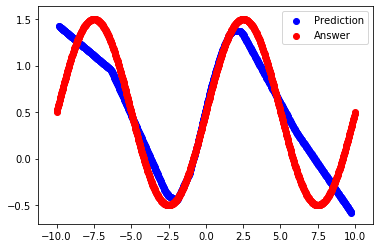

1000/1000 [==============================] - 0s 13us/step
Iterations: 800	 loss(mse): 0.04195


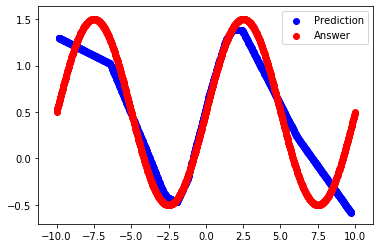

1000/1000 [==============================] - 0s 24us/step
Iterations: 900	 loss(mse): 0.03574


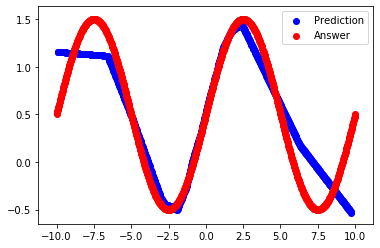

1000/1000 [==============================] - 0s 24us/step
Iterations: 1000	 loss(mse): 0.02893


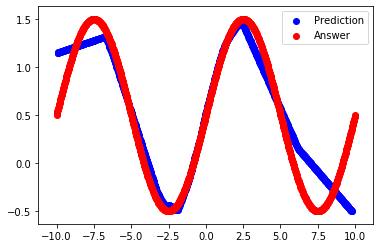

1000/1000 [==============================] - 0s 23us/step
Iterations: 1100	 loss(mse): 0.02348


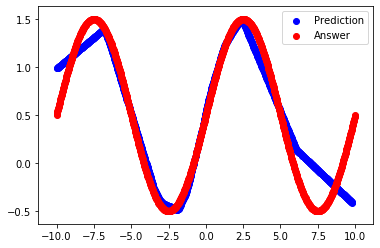

1000/1000 [==============================] - 0s 32us/step
Iterations: 1200	 loss(mse): 0.01994


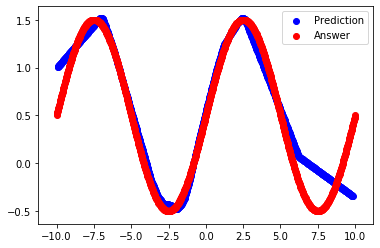

1000/1000 [==============================] - 0s 32us/step
Iterations: 1300	 loss(mse): 0.01491


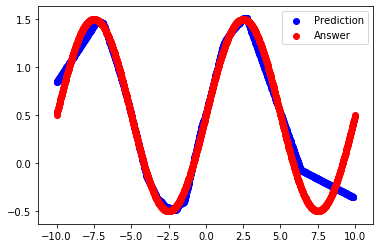

1000/1000 [==============================] - 0s 28us/step
Iterations: 1400	 loss(mse): 0.01135


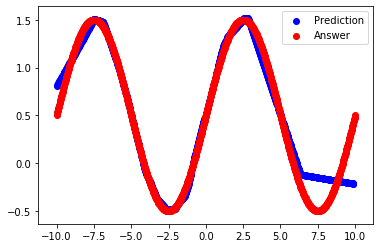

1000/1000 [==============================] - 0s 29us/step
Iterations: 1500	 loss(mse): 0.00898


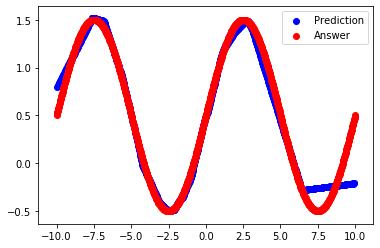

1000/1000 [==============================] - 0s 24us/step
Iterations: 1600	 loss(mse): 0.00617


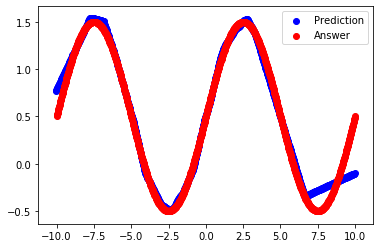

1000/1000 [==============================] - 0s 24us/step
Iterations: 1700	 loss(mse): 0.00404


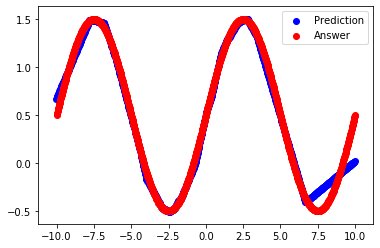

1000/1000 [==============================] - 0s 14us/step
Iterations: 1800	 loss(mse): 0.00319


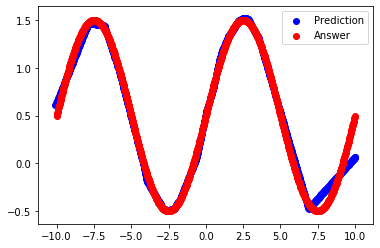

1000/1000 [==============================] - 0s 34us/step
Iterations: 1900	 loss(mse): 0.00257


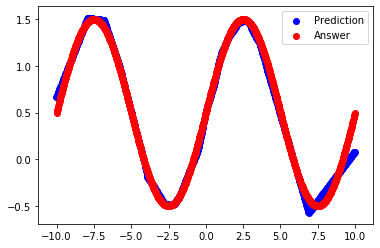

1000/1000 [==============================] - 0s 25us/step
Iterations: 2000	 loss(mse): 0.00185


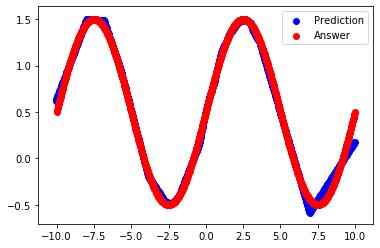

1000/1000 [==============================] - 0s 32us/step
Iterations: 2100	 loss(mse): 0.00164


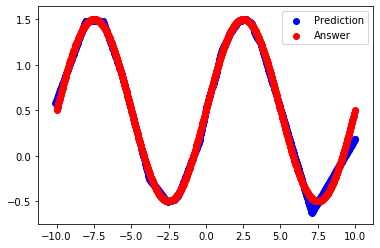

1000/1000 [==============================] - 0s 13us/step
Iterations: 2200	 loss(mse): 0.00170


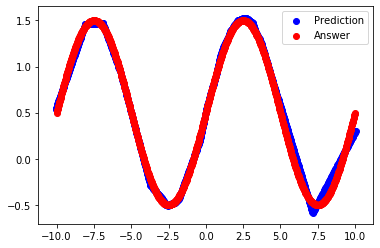

1000/1000 [==============================] - 0s 13us/step
Iterations: 2300	 loss(mse): 0.00124


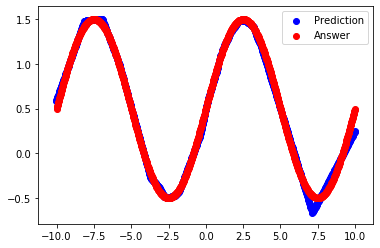

1000/1000 [==============================] - 0s 29us/step
Iterations: 2400	 loss(mse): 0.00113


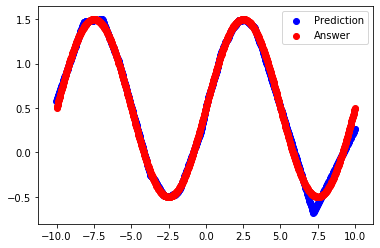

1000/1000 [==============================] - 0s 31us/step
Iterations: 2500	 loss(mse): 0.00099


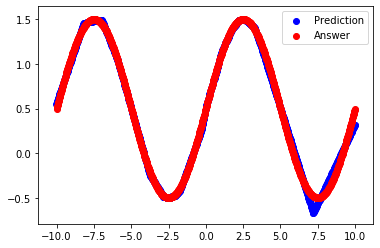

1000/1000 [==============================] - 0s 30us/step
Iterations: 2600	 loss(mse): 0.00099


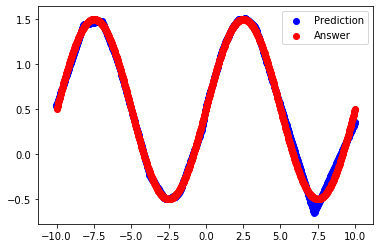

1000/1000 [==============================] - 0s 36us/step
Iterations: 2700	 loss(mse): 0.00103


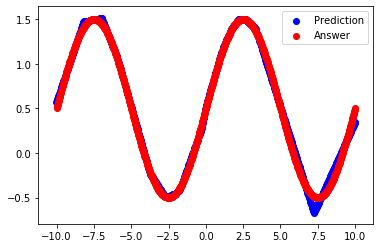

1000/1000 [==============================] - 0s 32us/step
Iterations: 2800	 loss(mse): 0.00121


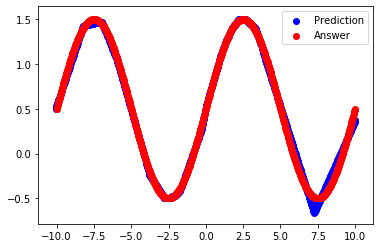

1000/1000 [==============================] - 0s 35us/step
Iterations: 2900	 loss(mse): 0.00114


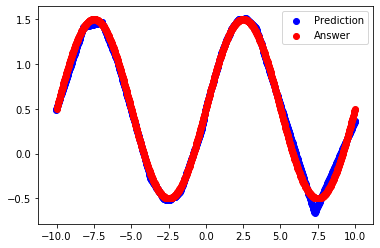

1000/1000 [==============================] - 0s 31us/step
Iterations: 3000	 loss(mse): 0.00102


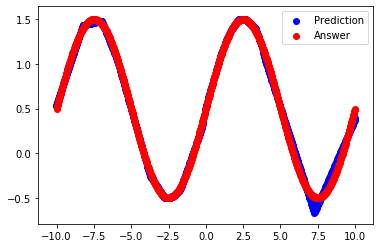

In [16]:
autoencoder.set_weights(initial_weights)
for i in range(30):
    autoencoder.fit(data, data, epochs=100, batch_size=256, validation_split=0.2, verbose=0)
    encoded_coor = encoder.predict(data)
    decoded_coor = decoder.predict(encoded_coor)
    px = []
    py = []
    for j in range(len(decoded_coor)):
        px.append(decoded_coor[j][0])
        py.append(decoded_coor[j][1])

    loss = autoencoder.evaluate(data, data)
    msg = 'Iterations: %d\t loss(mse): %.5f' % ((i+1)*100,loss)
    print(msg)
    plt.scatter(px,py,color='b',label = 'Prediction')
    plt.scatter(x1,x2,color='r',label = 'Answer')
    plt.legend()
    plt.show()

#### 可以sin需要花更多的epochs次數才能得到比較好的結果(這次提升到3000次)

#### 我們換成 同一個邊界範圍的tanh函數跑跑看

In [17]:
def MyFunctionTanh(n=1000):
    x1 = []
    x2 = np.linspace(-10,10,n)
    for i in range(len(x2)):
        x1.append(tanh(0.2*pi*x2[i])+0.5)
    x1 = np.asarray(x1)
    return x2, x1

x1, x2 = MyFunctionTanh(1000)

data = list([x,y] for x,y in zip(x1,x2))
data = np.asarray(data)
np.random.shuffle(data)

1000/1000 [==============================] - 0s 30us/step
Iterations: 100	 loss(mse): 0.03563


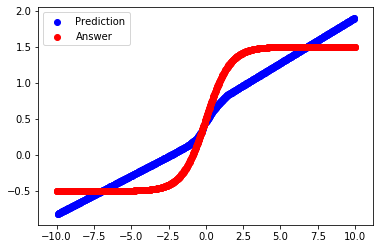

1000/1000 [==============================] - 0s 14us/step
Iterations: 200	 loss(mse): 0.00652


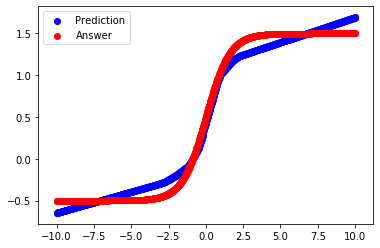

1000/1000 [==============================] - 0s 29us/step
Iterations: 300	 loss(mse): 0.00077


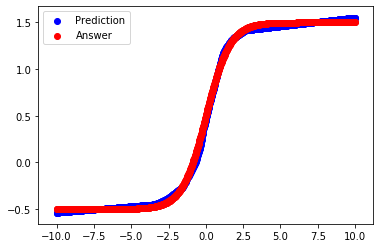

1000/1000 [==============================] - 0s 14us/step
Iterations: 400	 loss(mse): 0.00024


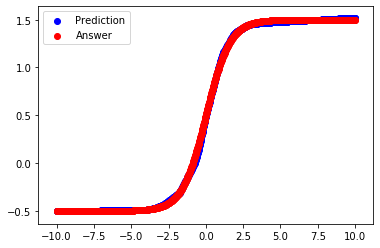

1000/1000 [==============================] - 0s 32us/step
Iterations: 500	 loss(mse): 0.00011


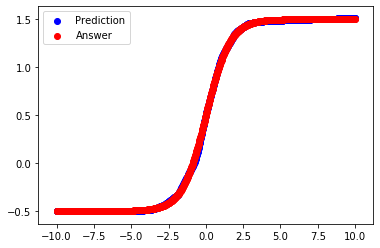

1000/1000 [==============================] - 0s 21us/step
Iterations: 600	 loss(mse): 0.00007


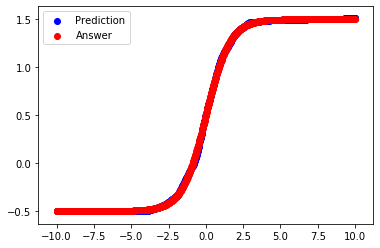

1000/1000 [==============================] - 0s 31us/step
Iterations: 700	 loss(mse): 0.00005


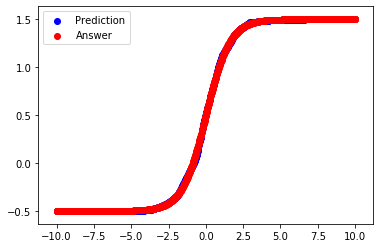

1000/1000 [==============================] - 0s 55us/step
Iterations: 800	 loss(mse): 0.00004


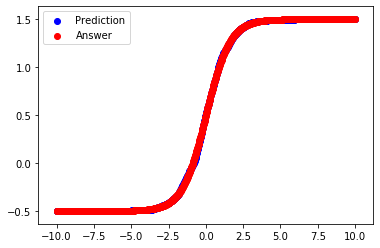

1000/1000 [==============================] - 0s 24us/step
Iterations: 900	 loss(mse): 0.00003


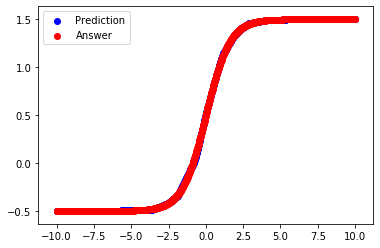

1000/1000 [==============================] - 0s 31us/step
Iterations: 1000	 loss(mse): 0.00002


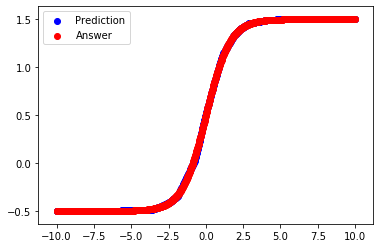

In [18]:
autoencoder.set_weights(initial_weights)
for i in range(10):
    autoencoder.fit(data, data, epochs=100, batch_size=256, validation_split=0.2, verbose=0)
    encoded_coor = encoder.predict(data)
    decoded_coor = decoder.predict(encoded_coor)
    px = []
    py = []
    for j in range(len(decoded_coor)):
        px.append(decoded_coor[j][0])
        py.append(decoded_coor[j][1])

    loss = autoencoder.evaluate(data, data)
    msg = 'Iterations: %d\t loss(mse): %.5f' % ((i+1)*100,loss)
    print(msg)
    plt.scatter(px,py,color='b',label = 'Prediction')
    plt.scatter(x1,x2,color='r',label = 'Answer')
    plt.legend()
    plt.show()

#### 可以tanh只需要花少少的epochs次數就能得到比較好的結果(大概500次就蠻接近了)

---
#### PART B: GAN

##### 繪製階段性訓練的成果。
##### 將網路產生的點(x 1, x2 )及訓練用的點繪製於二維座標空間內
##### 這裡我們將函數的顯示範圍 控制在 -10 ~ 10 之間
##### 而 T值 範圍故意調在 -3 ~ 3 之間
##### 試試看有沒有辦法 用較小範圍的一維變化值 映射出 較大的二維空間 


In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

def get_y(x):
    return math.cos( 0.2 * math.pi * x) + 0.5

def sample_data(n=10000, scale=20):
    data = []

    x = scale*(np.random.random_sample((n,)))-10

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])
    
    return np.array(data)

T_left_range = -3
T_right_range = 3
def sample_Z(m, n):
    return np.random.uniform(T_left_range, T_right_range, size=[m, n])

---
#### build GAN

In [20]:
def generator(Z,reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,16,activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,16,activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

def discriminator(X,reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,16,activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,16,activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3

tf.reset_default_graph()
X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,1])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


---
#### 下面這個 cell 就可以重複執行來測試了～
#### 我們讓每個epoch 跑的訓練點個數為 256
#### epoch 設定 2000 次
#### 每200次 印出目前訓練成果

Iterations: 0	 Discriminator loss: 1.5121	 Generator loss: 0.7243


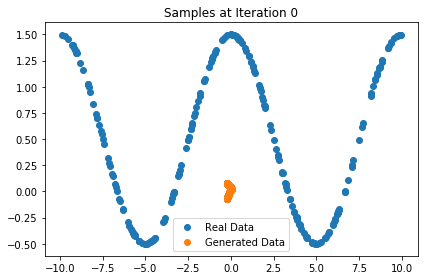

Iterations: 200	 Discriminator loss: 1.4049	 Generator loss: 0.6757


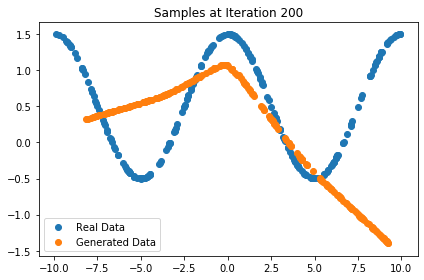

Iterations: 400	 Discriminator loss: 1.3240	 Generator loss: 0.8107


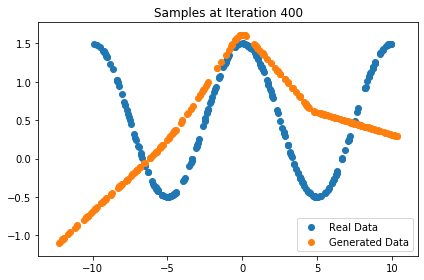

Iterations: 600	 Discriminator loss: 1.4042	 Generator loss: 0.7587


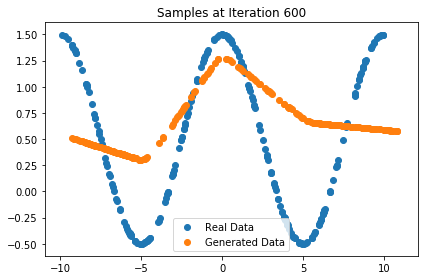

Iterations: 800	 Discriminator loss: 1.2036	 Generator loss: 0.7828


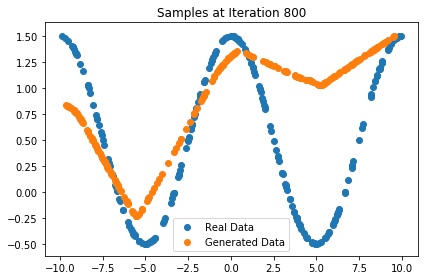

Iterations: 1000	 Discriminator loss: 1.2409	 Generator loss: 0.7957


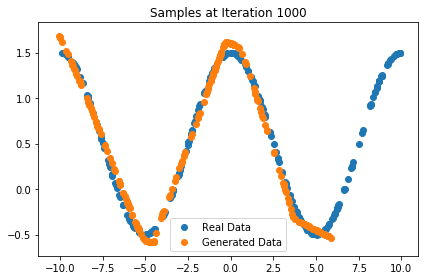

Iterations: 1200	 Discriminator loss: 1.3902	 Generator loss: 0.7015


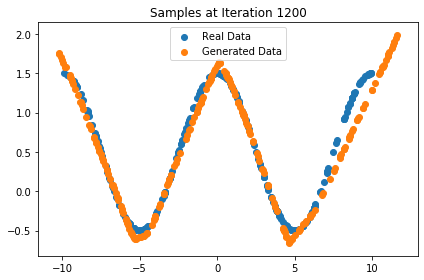

Iterations: 1400	 Discriminator loss: 1.3830	 Generator loss: 0.6986


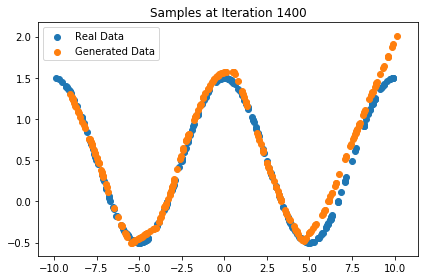

Iterations: 1600	 Discriminator loss: 1.3843	 Generator loss: 0.7256


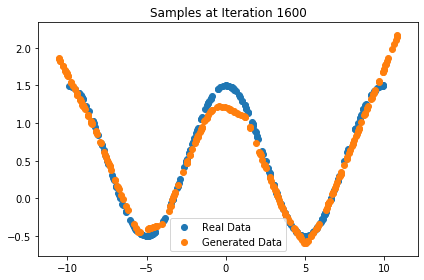

Iterations: 1800	 Discriminator loss: 1.3785	 Generator loss: 0.6600


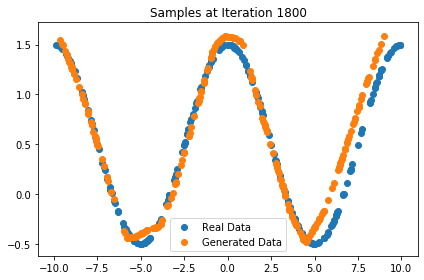

Iterations: 2000	 Discriminator loss: 1.3854	 Generator loss: 0.6911


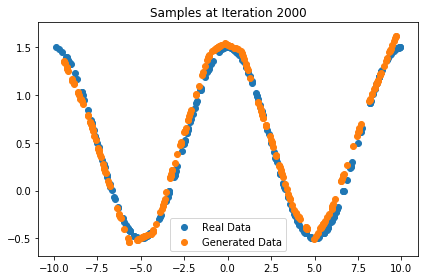

In [21]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
epoch = 2000
image_show_step = 200

nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

for i in range(epoch+1):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 1)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})    #train discriminator
    #rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})    #train generator
    #rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    if i%image_show_step == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()

#### 可以看到 GAN 產生的資料點 有越來越貼近函數
----
#### 探討不同 t 值對應於空間的點
##### 我們給出 2 個超過 T預設範圍（-3,3）的點 (左右邊各一個)
##### 以及 5個 在設範圍內的點

不同 t 值對應於空間的點


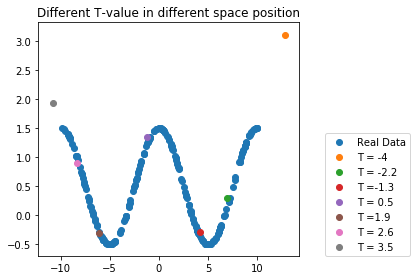

In [22]:
print("不同 t 值對應於空間的點")
plt.figure()
xax = plt.scatter(x_plot[:,0], x_plot[:,1])

Z_batch = [[-4]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_1 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[-2.2]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_2 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[-1.3]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_3 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[0.4]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_4 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[1.9]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_5 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[2.6]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_6 = plt.scatter(g_plot[:,0],g_plot[:,1])

Z_batch = [[3.5]]
g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
gax_7 = plt.scatter(g_plot[:,0],g_plot[:,1])

plt.legend((xax, gax_1, gax_2, gax_3, gax_4, gax_5, gax_6, gax_7), \
           ("Real Data", "T = -4", "T = -2.2", "T =-1.3", "T = 0.5", "T =1.9", "T = 2.6", "T = 3.5",),loc=[1.1, 0])

plt.title('Different T-value in different space position')
plt.tight_layout()
plt.show()

sess.close()

#### 可以看到 在T的預設範圍內(-3,3)，
#### 可以用一維的T映射到二維的cos函數
#### ( 一維[-3,3]的範圍 映射到二維cos函數的[-10,10]的範圍 )
#### 映射的分佈情形 大致為平均分散的分佈。
#### 而超過預設範圍的資料，
#### 則以類似原資料邊緣的方向 繼續往同方向延伸的方式出現
#### 變得沒有參考價值
---
##### 接著我們測試如果訓練之點數 減少的情形
##### 每個epoch 給的點數量 從256 降到32

Iterations: 0	 Discriminator loss: 1.5569	 Generator loss: 0.7309


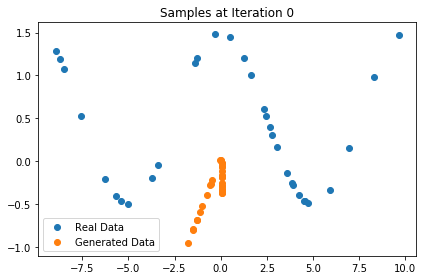

Iterations: 200	 Discriminator loss: 1.3122	 Generator loss: 0.6627


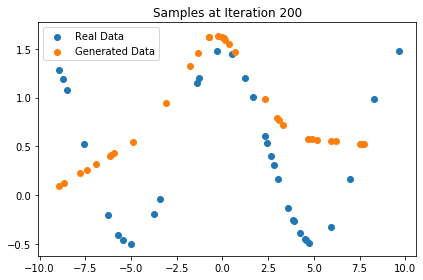

Iterations: 400	 Discriminator loss: 1.3818	 Generator loss: 0.7310


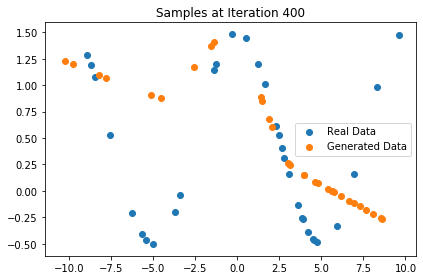

Iterations: 600	 Discriminator loss: 1.3695	 Generator loss: 0.6875


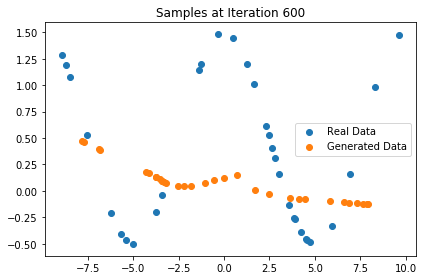

Iterations: 800	 Discriminator loss: 1.2482	 Generator loss: 0.8470


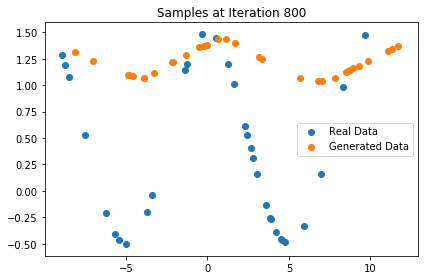

Iterations: 1000	 Discriminator loss: 1.4131	 Generator loss: 0.8924


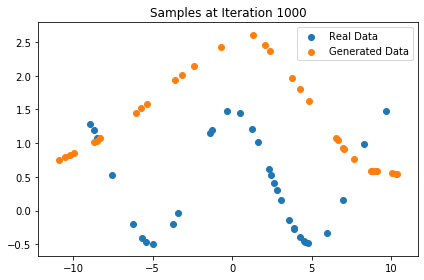

Iterations: 1200	 Discriminator loss: 1.3737	 Generator loss: 0.7140


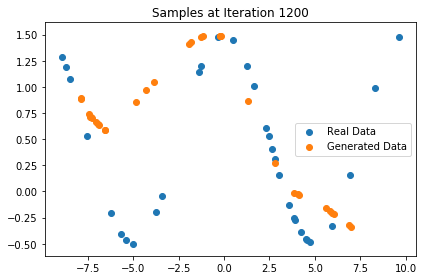

Iterations: 1400	 Discriminator loss: 1.4340	 Generator loss: 0.6905


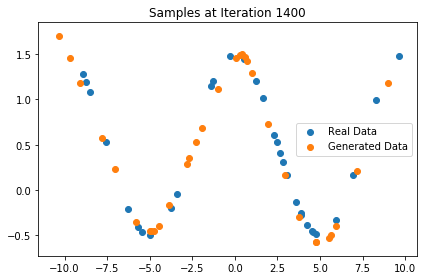

Iterations: 1600	 Discriminator loss: 1.2933	 Generator loss: 0.6863


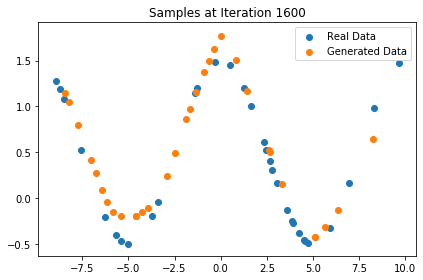

Iterations: 1800	 Discriminator loss: 1.3788	 Generator loss: 0.7384


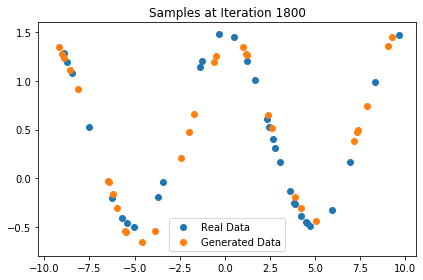

Iterations: 2000	 Discriminator loss: 1.3852	 Generator loss: 0.6927


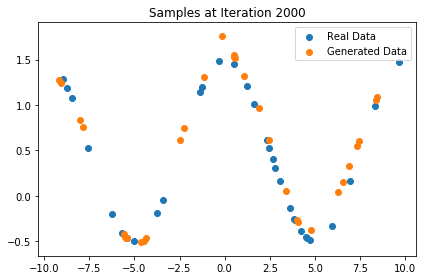

In [23]:
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 32
epoch = 2000
image_show_step = 200

nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

for i in range(epoch+1):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 1)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})    #train discriminator
    #rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})    #train generator
    #rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    if i%image_show_step == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()
sess.close()

#### 可以看到資料訓練之點數減少後，
#### GAN的學習變得比較慢，但仍有慢慢在嘗試吻合函數圖形的趨勢
---
#### 嘗試針對其他不同函數產生之(x1 , x2 )的訓練結果：
#### 我們換成 同一個邊界範圍的sin函數跑跑看

Iterations: 0	 Discriminator loss: 1.3067	 Generator loss: 0.4924


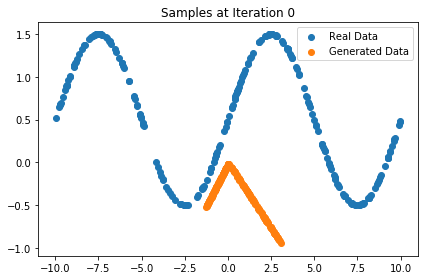

Iterations: 200	 Discriminator loss: 1.3872	 Generator loss: 0.7172


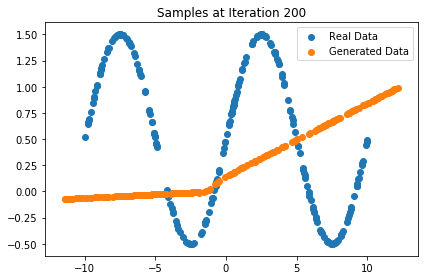

Iterations: 400	 Discriminator loss: 1.3386	 Generator loss: 0.6613


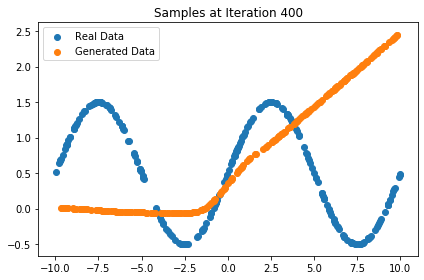

Iterations: 600	 Discriminator loss: 1.3471	 Generator loss: 0.7866


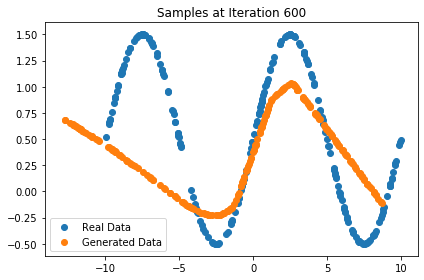

Iterations: 800	 Discriminator loss: 1.3816	 Generator loss: 0.7457


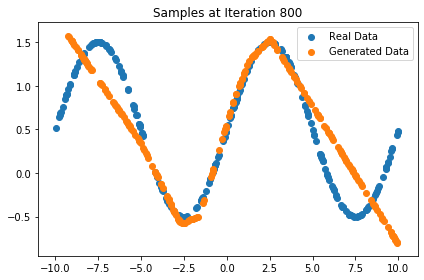

Iterations: 1000	 Discriminator loss: 1.3598	 Generator loss: 0.7307


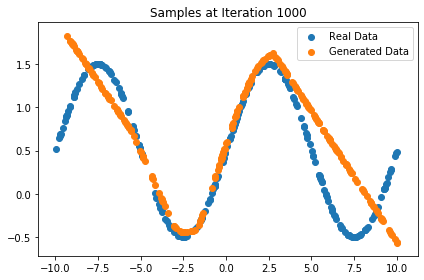

Iterations: 1200	 Discriminator loss: 1.3370	 Generator loss: 0.7041


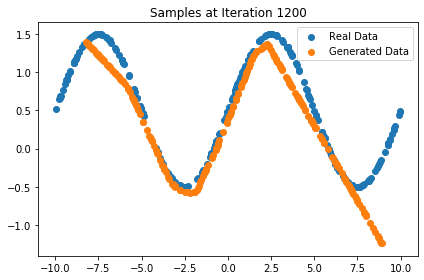

Iterations: 1400	 Discriminator loss: 1.3682	 Generator loss: 0.7953


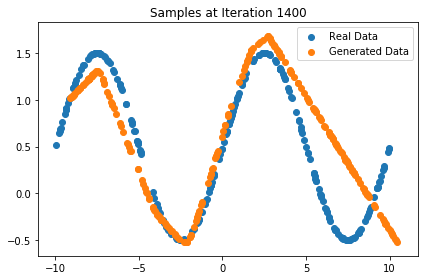

Iterations: 1600	 Discriminator loss: 1.3605	 Generator loss: 0.6659


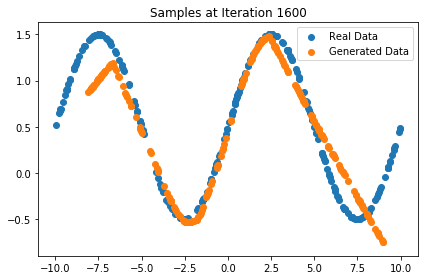

Iterations: 1800	 Discriminator loss: 1.3483	 Generator loss: 0.6903


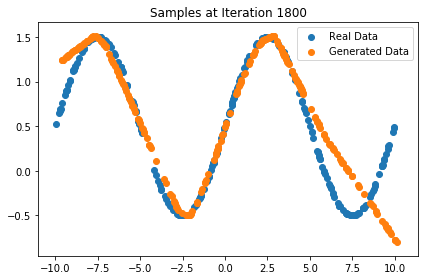

Iterations: 2000	 Discriminator loss: 1.2999	 Generator loss: 0.6516


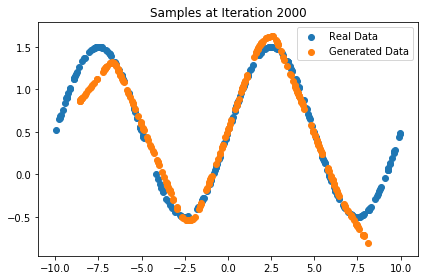

In [24]:
def new_get_y(x):
    return math.sin( 0.2 * math.pi * x) + 0.5

def new_sample_data(n=10000, scale=20):
    data = []

    x = scale*(np.random.random_sample((n,)))-10

    for i in range(n):
        yi = new_get_y(x[i])
        data.append([x[i], yi])
    
    return np.array(data)

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
epoch = 2000
image_show_step = 200

nd_steps = 10
ng_steps = 10

x_plot = new_sample_data(n=batch_size)

for i in range(epoch+1):
    X_batch = new_sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 1)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})    #train discriminator
    #rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})    #train generator
    #rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    if i%image_show_step == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()

sess.close()

#### 可以看到換成sin後 
#### 有隨著練次數逐漸變好
#### 但函數吻合的情形沒有像原本的cos那麼貼近
#### 我們猜測是因為 同樣的原始資料範圍內[-10,10]
#### sin函數比cos多了一個轉彎
#### 因此學習的難度上升了一些
---
#### 接著我們換成同一個邊界範圍的tanh 跑跑看

Iterations: 0	 Discriminator loss: 1.9573	 Generator loss: 0.6927


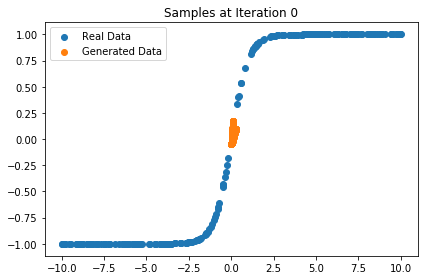

Iterations: 200	 Discriminator loss: 1.2067	 Generator loss: 0.6865


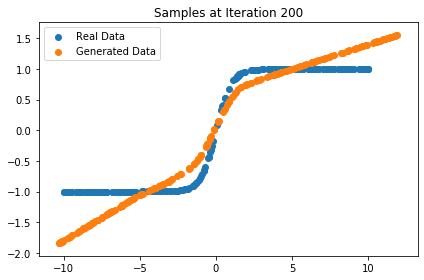

Iterations: 400	 Discriminator loss: 1.3671	 Generator loss: 0.6921


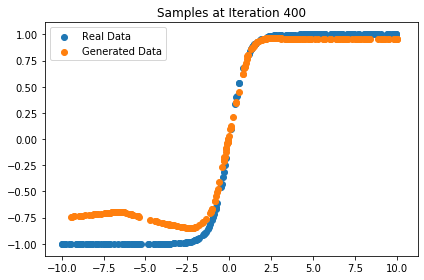

Iterations: 600	 Discriminator loss: 1.3980	 Generator loss: 0.7441


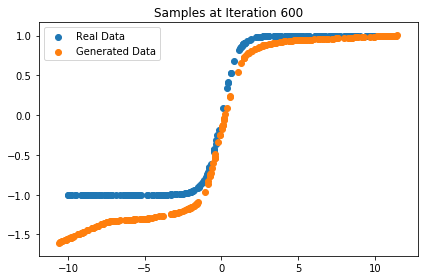

Iterations: 800	 Discriminator loss: 1.3868	 Generator loss: 0.6819


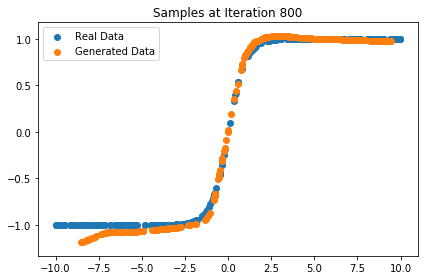

Iterations: 1000	 Discriminator loss: 1.3883	 Generator loss: 0.6943


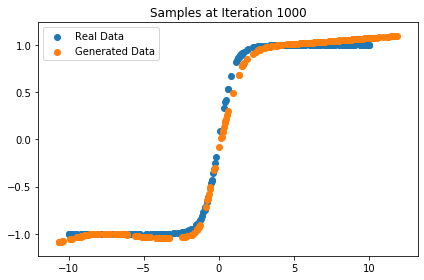

Iterations: 1200	 Discriminator loss: 1.3846	 Generator loss: 0.6931


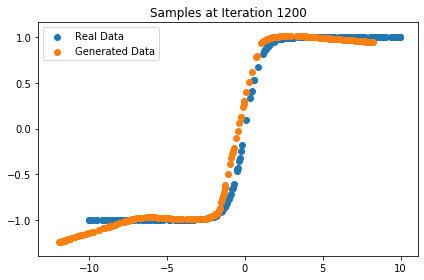

Iterations: 1400	 Discriminator loss: 1.3795	 Generator loss: 0.7115


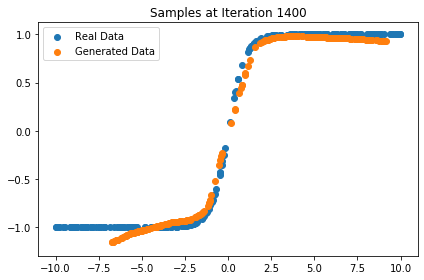

Iterations: 1600	 Discriminator loss: 1.3852	 Generator loss: 0.6958


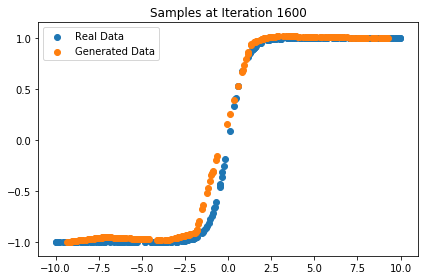

Iterations: 1800	 Discriminator loss: 1.3867	 Generator loss: 0.6913


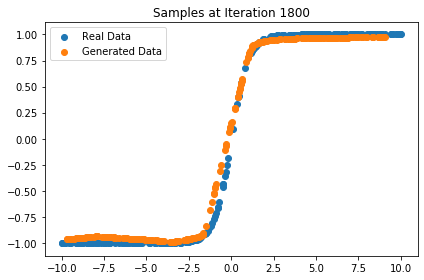

Iterations: 2000	 Discriminator loss: 1.3814	 Generator loss: 0.6896


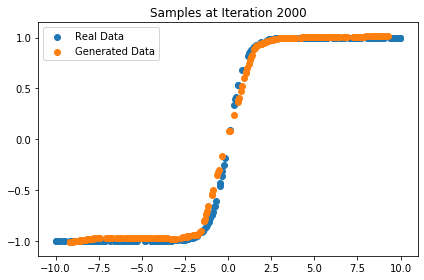

In [25]:
def tanh_get_y(x):
    return math.tanh( x )

def tanh_sample_data(n=10000, scale=20):
    data = []

    x = scale*(np.random.random_sample((n,)))-10

    for i in range(n):
        yi = tanh_get_y(x[i])
        data.append([x[i], yi])
    
    return np.array(data)

sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
epoch = 2000
image_show_step = 200

nd_steps = 10
ng_steps = 10

x_plot = tanh_sample_data(n=batch_size)

for i in range(epoch+1):
    X_batch = tanh_sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 1)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})    #train discriminator
    #rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})    #train generator
    #rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    if i%image_show_step == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.show()

sess.close()

#### 我們可以看到tanh的圖形比較簡單
#### 因此在很少的次數內就能學習的差不多了